In [1]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import pennylane as qml


In [4]:
def prepare_molecule(bond_dist):
    """
    Function to initialize the molecule and return the hamiltonian and qubits.
    """
    symbols = ["H", "H"]
    geometry = np.array([[0., 0., -bond_dist/2], [0., 0., bond_dist/2]])  # Coordinates in Bohr
    molecule = qml.qchem.Molecule(symbols, geometry)
    hamiltonian, qubits = qml.qchem.molecular_hamiltonian(molecule)
    
    return hamiltonian, qubits

def advanced_ansatz(params):
    """
    Function to define the advanced quantum circuit ansatz using single excitations.
    """
    hf_state = np.array([1, 1, 0, 0])  # Hartree-Fock state
    # Prepare the Hartree-Fock state
    qml.BasisState(hf_state, wires=[0, 1, 2, 3])
    # Define single excitations
    qml.SingleExcitation(params[0], wires=[0, 2])
    qml.SingleExcitation(params[1], wires=[1, 3])
    qml.SingleExcitation(params[2], wires=[0, 3])
    qml.SingleExcitation(params[3], wires=[1, 2])

def create_qnode(hamiltonian, qubits):
    """
    Function to create a QNode that computes the expectation value of the Hamiltonian.
    """
    dev = qml.device('default.qubit', wires=qubits)    

    @qml.qnode(dev,interface='torch')
    def circuit(params):
        advanced_ansatz(params)
        return qml.expval(hamiltonian)
    
    return circuit

def torch_optimize(qnode, init_params, step_num, optimizer_class, lr, patience=50, verbose=False):
    """
    Function to perform optimization using torch and the given optimizer, with added patience for convergence.
    """
    params = torch.from_numpy(np.copy(init_params)).float()
    params.requires_grad = True

    optimizer = optimizer_class(params=[params], lr=lr)  # Initialize optimizer with the given parameters
    costs = []
    times = []
    prev_cost = float("-inf")
    conv_tol = 1e-06
    patience_counter = 0

    for i in range(step_num):
        # Define the closure for L-BFGS optimizer
        start_time = time.time()
        
        def closure():
            optimizer.zero_grad()
            cost = qnode(params)
            if cost.requires_grad:
                cost.backward()
            return cost.detach().numpy()

        # Perform optimization step
        cost = optimizer.step(closure)
        costs.append(cost)
        
        # Check for convergence with patience
        conv = np.abs(cost - prev_cost)
        if conv <= conv_tol:
            patience_counter += 1
            if patience_counter >= patience:
                break
        else:
            patience_counter = 0  # Reset patience if cost changes significantly
        
        prev_cost = cost
        times.append(time.time() - start_time)
        
        if verbose and (i + 1) % 100 == 0:
            print(f"Cost after step {i + 1}: {costs[-1]}")
    
    return costs, times, i

def plot_convergence(costs):
    """
    Function to plot the energy convergence during optimization.
    """
    plt.plot(range(len(costs)), costs, '-o', label="Energy", markersize=3)
    plt.xlabel('Iteration')
    plt.ylabel('Energy (Hartree)')
    plt.title('Energy Convergence with UCCS-like Ansatz for H2')
    plt.legend()
    plt.grid(True)
    plt.show()

def optimizer_run(opt, step_num, bond_dist, lr, verbose=True):
    """
    Main function that prepares the molecule, initializes the QNode,
    runs optimization, and plots the results.
    """
    # Prepare the molecule and hamiltonian
    hamiltonian, qubits = prepare_molecule(bond_dist)
    
    # Create QNode
    qnode = create_qnode(hamiltonian, qubits)

    # Initialize parameters and run optimization
    init_params = np.random.normal(0, 0.1, 4)
    costs, times, steps = torch_optimize(qnode, init_params, step_num, opt, lr, verbose=verbose)
    if (verbose):
        # Plot the energy convergence
        plot_convergence(costs)
    
    return costs, times, steps



/home/somay/.local/lib/python3.10/site-packages/pennylane/math/interface_utils.py:127: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


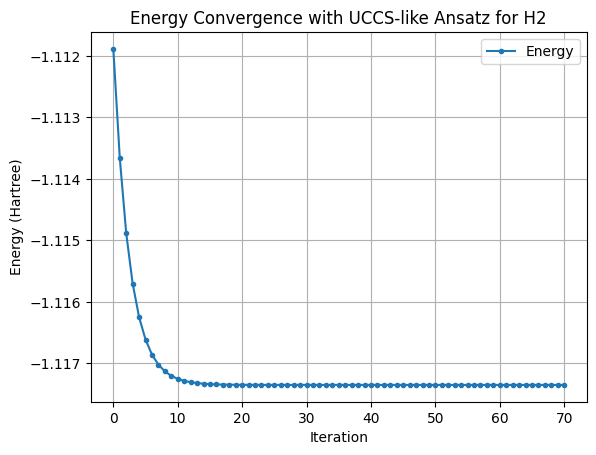

-1.117349055258293 70


In [3]:
costs, times, steps = optimizer_run(torch.optim.LBFGS, step_num=10000, bond_dist = 1.32280828, lr = 1e-2,  verbose=True)
print(costs[-1],steps)

In [5]:
def energy_vs_bondLength(optimzer):
    # Define a range of bond lengths (in Bohr, 1 Bohr = 0.529 Å)
    bond_lengths = np.linspace(0.5, 3.0, 10)  # From 0.5 to 3.0 Bohr

    # Lists to store results
    final_energies = []
    convergence_iterations = []

    # Loop over bond lengths
    for bond_length in bond_lengths:
        
        costs, times, steps = optimizer_run(optimzer, step_num = 10000, bond_dist = bond_length, lr = 1e-2,  verbose=False)
        # Store results
        final_energies.append(costs[-1])
        convergence_iterations.append(steps + 1)
        print(f"Bond length: {bond_length:.2f} Bohr, Energy: {costs[-1]:.6f} Ha, Iterations: {steps + 1}")

    # Create two subplots
    plt.figure(figsize=(12, 5))

    # Plot 1: Energy vs. Bond Length (Potential Energy Curve)
    plt.subplot(1, 2, 1)
    plt.plot(bond_lengths, final_energies, 'o-', label="Ground State Energy")
    plt.xlabel('Bond Length (Bohr)')
    plt.ylabel('Energy (Hartree)')
    plt.title('Potential Energy Curve of H2')
    plt.legend()
    plt.grid(True)

/home/somay/.local/lib/python3.10/site-packages/pennylane/math/interface_utils.py:127: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Bond length: 0.50 Bohr, Energy: -0.403295 Ha, Iterations: 444
Bond length: 0.78 Bohr, Energy: -0.926625 Ha, Iterations: 354
Bond length: 1.06 Bohr, Energy: -1.083641 Ha, Iterations: 519
Bond length: 1.33 Bohr, Energy: -1.117361 Ha, Iterations: 614
Bond length: 1.61 Bohr, Energy: -1.101865 Ha, Iterations: 571
Bond length: 1.89 Bohr, Energy: -1.065953 Ha, Iterations: 683
Bond length: 2.17 Bohr, Energy: -1.021875 Ha, Iterations: 301
Bond length: 2.44 Bohr, Energy: -0.984622 Ha, Iterations: 4143
Bond length: 2.72 Bohr, Energy: -0.963344 Ha, Iterations: 4103
Bond length: 3.00 Bohr, Energy: -0.950796 Ha, Iterations: 3834


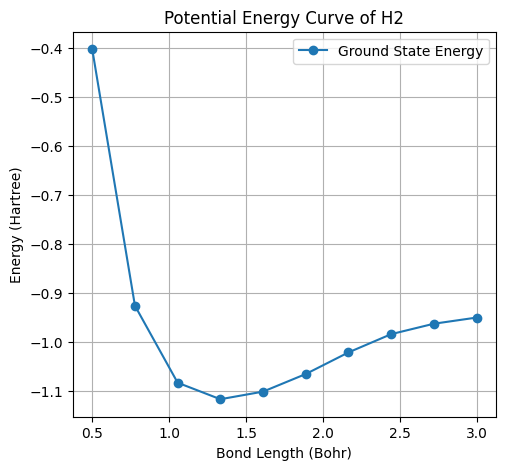

In [6]:
energy_vs_bondLength(torch.optim.SGD)